In [1]:
!pip install git+https://github.com/pnnl/DeepDataProfiler.git


<img src="images/vgg_profiling.png" alt="VGG Profiling Image" style="width: 400px;float: right;margin: 10pt"/>

# Deep Data Profiler(DDP)

DDP characterizes both the data and the model, pointing to the most influential neurons and weights used for classification and identifying the inter-relationships between neurons in the profiled layers. DDP is currently implemented for Pytorch modules: 
- torch.nn.Linear,
- torch.nn.MaxPool2d,
- torch.nn.AdaptiveAvgPool2d,
- torch.nn.Conv2d

Using these modules, DDP can construct profiles for sequential (VGG-like) and Resnet architectures.

### Important Terms
- Layers - collections of modules across the model. We group weighted modules with their activations and treat these as a single layer. Pooling modules are given their own layers as they affect the indices of contributing neurons.
- Neuron - the index of an input or output tensor for each layer, we identify the most influential neurons
    - A neuron can refer to either a single element or a channel of a tensor, depending on the profile.
- Synapse - a tuple of input and output neurons (and weight indices where appropriate) within a layer
- Profile instance - the critical set of neurons and synapses (up to a threshold value) that leads to a final predicted class
- Threshold - a parameter to determine the neurons and synapses used for the profile
- Class Profile - an aggregation of profile instances for inputs from the same class
- Jaccard metrics 
    - Computes similarity between profiles
    - Can cluster sets of profiles

### Import libraries and data

In [2]:
import cv2
import deep_data_profiler as ddp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torchvision.models.resnet as resnet
import torchvision.models.vgg as vgg
from torchvision.transforms import Compose, Normalize
from torchvision.transforms.functional import to_tensor

In [3]:
## To ensure reproducibility we set the pytorch seed. This only works if the versioning of libraries is held
## constant
torch.manual_seed(0)
## We will also specify the device. The profiling code will run on cpu or cuda.
device=torch.device('cpu')

---
<img src="images/eagleimage.png" alt="VGG Profiling Image" style="width: 175px;float: right;margin: 15pt"/>

# How do we compute a profile?


Profiling requires a pretrained model and data that mirrors the training data. In this example the model is the pretrained
Pytorch VGG16 model. We create a profiler for the data by instantiating the class <code>ddp.TorchProfiler</code> with the 
pretrained model.

We preprocess the eagle image on the right into Pytorch tensors suitable as input for the VGG16 model. To create a 
profile for these images we then use the <code>ddp.TorchProfiler.create_profile()</code> method on the image.

## 1. Generate the data
We preprocess an eagle image from Imagenet by applying the transformations that were used on the training set (i.e. normalizing, resizing, etc.):

In [4]:
### Uncomment the following to run in Colab
!wget -qnc "https://raw.githubusercontent.com/pnnl/DeepDataProfiler/master/tutorials/images/n01614925/ILSVRC2012_val_00046632.JPEG"
img = cv2.imread('ILSVRC2012_val_00046632.JPEG')

### Uncomment the following to run locally
# imagepath = 'images/n01614925/ILSVRC2012_val_00046632.JPEG'
# img = cv2.imread(imagepath)

In [5]:
def torch_image(img):
    """normalize the values and resize for processing"""
    norm=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    normalize = Compose([Normalize(mean=norm[0], std=norm[1])])
    img = np.expand_dims(img, 2).repeat(3, axis=2) if len(img.shape) == 2 else img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = to_tensor(img)
    return torch.unsqueeze(normalize(img),0)

timage = torch_image(img)

## 2. Choose a model

We create an instance of the `ddp.TorchProfiler` class, which allows us to use all of the DDP profiling methods for the model. We will highlight some of these methods, including:

- `available_modules()` : returns a list of available module names and associated models
- `create_layers()` : creates a dictionary of layers to profile
- `create_profile()` : generates a profile for a single input as it passes through the layers
- `dict_view()` : reformats the profile using dictionaries to represent the counts and weights

Here we instantiate the PyTorch VGG-16 model and its DDP Profiler, `profiler`, with a threshold.

Uncomment the Resnet code to see the tutorial with ResNet.

In [6]:
threshold=0.1
model = vgg.vgg16(pretrained=True).eval()
# model = resnet.resnet18(pretrained=True).eval()
profiler = ddp.TorchProfiler(model)

## 3. Decide which layers to profile. 
A profile represents connections between the layers of the network, and we may not always want to profile all of the layers. First let's take a look at the available modules in each layer.

In [7]:
profiler.model.available_modules()

OrderedDict([('features.0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.1', ReLU(inplace=True)),
             ('features.2',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.3', ReLU(inplace=True)),
             ('features.4',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.5',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.6', ReLU(inplace=True)),
             ('features.7',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.8', ReLU(inplace=True)),
             ('features.9',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.10',
              Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
           

For profiling, layers are weighted modules or pooling modules. We construct a layer dictionary to pass to the profiler.

In [8]:
## note the helper function referenced in each layer start with _contrib and 
## refer to the type of Pytorch layer being profiled
layerdict = profiler.create_layers();layerdict

OrderedDict([(0, [['x_in'], 'contrib_identity']),
             (1, [['features.0', 'features.1'], 'contrib_conv2d']),
             (2, [['features.2', 'features.3'], 'contrib_conv2d']),
             (3, [['features.4'], 'contrib_max2d']),
             (4, [['features.5', 'features.6'], 'contrib_conv2d']),
             (5, [['features.7', 'features.8'], 'contrib_conv2d']),
             (6, [['features.9'], 'contrib_max2d']),
             (7, [['features.10', 'features.11'], 'contrib_conv2d']),
             (8, [['features.12', 'features.13'], 'contrib_conv2d']),
             (9, [['features.14', 'features.15'], 'contrib_conv2d']),
             (10, [['features.16'], 'contrib_max2d']),
             (11, [['features.17', 'features.18'], 'contrib_conv2d']),
             (12, [['features.19', 'features.20'], 'contrib_conv2d']),
             (13, [['features.21', 'features.22'], 'contrib_conv2d']),
             (14, [['features.23'], 'contrib_max2d']),
             (15, [['features.24', 'fea

In this example, we will profile <b>all layers</b> of the model. To profile a subset of the layers, pass either a list of layers $[L_1, L_2, \dots, L_n]$ or a tuple-formatted range $(L_1, L_n) = [L_1, L_2, \dots, L_{n-1}]$ to <code>TorchProfiler.create_profile()</code> as the <code>layers_to_profile</code> argument.

## 4. Instantiate the Profile
**The primary purpose of a `ddp.TorchProfiler` object is to generate `ddp.Profile` objects for input data as it passes through the layers of a model.**

We compute both a channel-wise and element-wise profile of the image, thresholding at 10%. This gives us two profiles that have been constructed using different definitions of the neuron, the significance of which we will discuss in the next section.

<b>Note:</b> You can experiment with different thresholds, though high thresholds will take longer to compute

In [9]:
%%time
channel_profile = profiler.create_profile(timage,
                                          layerdict,
                                          threshold=0.1,
                                          channels=True)  

CPU times: user 1.99 s, sys: 925 ms, total: 2.91 s
Wall time: 1.99 s


In [10]:
%%time
element_profile = profiler.create_profile(timage,
                                          layerdict,
                                          threshold=0.1,
                                          channels=False)  

CPU times: user 4.24 s, sys: 1.55 s, total: 5.78 s
Wall time: 4.22 s


## 5. Plot the Profile Graph
Tutorial 2 gives a detailed walkthrough of this process.

In [11]:
profile_dict = profiler.dict_view(channel_profile)
T = ddp.tuples_from_dict(profile_dict.synapse_weights)
G = ddp.graph_from_tuples(T)

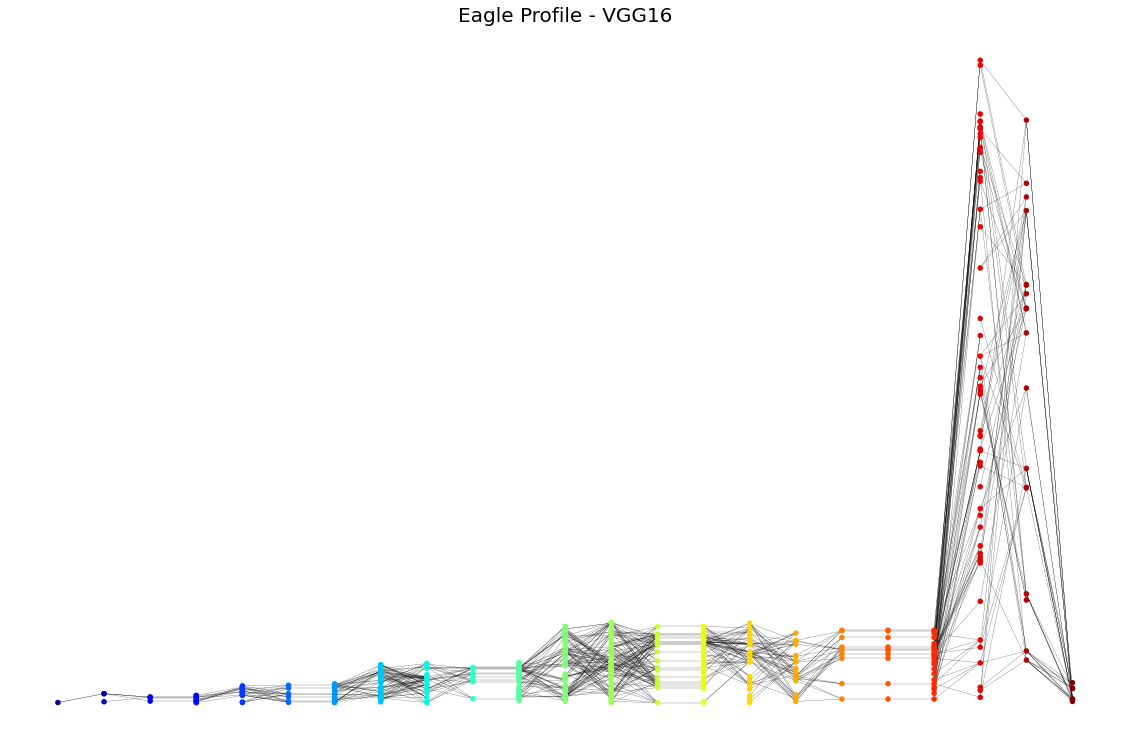

In [12]:
fig, ax = plt.subplots(figsize=(20,13))
ax.axis('off')
# position nodes by layer and index
position = {node:(node[0],node[1]) for node in G.nodes}
ax.set_title('Eagle Profile - VGG16', fontsize=20)
nx.draw(G,ax=ax,node_size=20,width=0.2, node_color=[v[0] for v in G.nodes], cmap='jet', pos=position, arrows=False)

---
# What is a neuron?

There are two different ways we can use neurons to track influence across the activations of a CNN. A "neuron" can refer to either a single channel of a convolutional layer, or to a single element. The choice of element or channel definition of neurons is consistent throughout a single profile.

<center><img src="images/synapsetypes.png" alt="Synapse Types" style="width: 800px;margin: 10pt"/></center>

 Each definition has its own strengths:
 - **Channel-wise** profiles are faster to compute, but lack granularity.
 - **Element-wise** profiles provide a more granular view of the network, but take require much more computing time and power.
 
There are some slight differences in the sparse matrix representations for the different neuron types, so both channel-wise and element-wise examples will be provided.
 
<b>Note</b>: The multiple definitions of *neuron* only apply to convolutional layers; the elements of a fully-connected linear layer are always treated as individual neurons. 

---
# What is in a Profile Object?

Let's look at a profile of a single image in the eagles class. We use the profile to find the largest contributors among the neurons and weights that lead to the final classification. Each profile contains python dictionaries of neuron_counts, synapse_counts, and synapse_weights, listing the significant contributors for the layers profiled.
Each profile has aggregation metrics of total and size. Profiles may be added together to form a new profile or added in place.

- <code>neuron_counts</code> : dictionary of sparse matrices, representing the number of significant synapses each neuron participates in at each layer.
- <code>neuron_weights</code> : dictionary of sparse matrices, representing the weight of influential neurons at each layer
- <code>synapse counts</code> : dictionary of sparse matrices, representing to the counts of connections between input and output neurons through each layer
- <code>synapse weights</code> :  dictionary of sparse matrices, representing the weighted connections between input and output neurons through each layer
- <code>num_inputs</code> : int, the number of input images a profile is constructed from (i.e. if you add two single image profiles with num_inputs = 1, the resulting aggregate profile will have num_inputs = 2
- <code>neuron_type</code> : string (optional), either 'channel' for a channel-wise profile, 'neuron' for a neuron-wise profile, or 'mixed' for an aggregate of profiles with mismatched types


One useful method for examining an existing profile is <code>ddp.TorchProfiler.dict_view()</code>, which takes a standard Profile object as input, and returns a new Profile object where dictionaries are used to represent the counts and weights data originally held by sparse matrices.

In [13]:
# dict_view returns a dummy Profile object that holds dictionary representations of each count and weight
channel_profile_dict = profiler.dict_view(channel_profile)
element_profile_dict = profiler.dict_view(element_profile)

There are two main cases where the dictionary view is important:
- Examining the synapses in a profile on Resnet architecture, where the preceding layer to layer $L$ is not necessarily the layer indexed $L-1$
- Using the <code>algorithms/homology</code> package to create a Profile Graph, where the dictionary view is required to construct the edges


## Neuron Counts: 
Note that each layer points at a sparse matrix representing the contributing neurons and the number of times each contributes within the layer. In this example we used a threshold of 0.1, meaning for each contributing neuron $n$, we searched for the smallest set of neurons $\{n_\alpha\}$ in the previous layer which would contribute to $10\%$ of the value of the neuron at $n$.

We refer to the dimensions of the layer activation tensor as $\text{num_channels}, \text{height}, $ and $\text{width}$.

In a **channel-wise** profile, neuron counts are shaped like a column vector of length $\text{num_channels}$. The entry at index $c$ gives the number of times channel $c$ has been identified as either influential within its layer, or as a contributor to an influential neuron in the following layer.

In [14]:
## Neuron counts of an early convolutional layer (4) with 128 channels
## the first index is 0 because the counts are a column vector
print(channel_profile.neuron_counts[4])

  (0, 1)	2
  (0, 4)	2
  (0, 46)	2
  (0, 48)	1
  (0, 49)	2
  (0, 55)	1
  (0, 59)	2
  (0, 69)	2
  (0, 71)	1
  (0, 72)	1
  (0, 75)	1
  (0, 77)	2
  (0, 89)	2
  (0, 93)	5
  (0, 99)	1
  (0, 100)	1
  (0, 107)	3


In an **element-wise** profile, neuron counts are a sparse matrix with shape: $\text{num_channels} \times (\text{height})(\text{width})$. The entry at index $c,i$ gives the number of times the element located at position $i$, a flattened spatial index of channel $c$, has been identified as either influential within its layer, or as a contributor to an influential neuron in the following layer.

In [15]:
print(element_profile.neuron_counts[4])

  (17, 4917)	1
  (46, 4440)	2
  (48, 7078)	1
  (69, 9026)	1
  (71, 6966)	1
  (72, 4065)	1
  (72, 4176)	1
  (72, 4553)	1
  (75, 9246)	1
  (78, 4804)	1
  (89, 9803)	1
  (93, 9025)	2
  (99, 3670)	1
  (100, 2855)	1
  (123, 4664)	1
  (124, 4692)	1
  (127, 4806)	1


Although these are two distinct profiles that identify different contributors, they represent two ways of describing the same model-data pairing. As such, there are several similarities between them to take note of. More than half of the channel indices from each set of neuron counts can be found in both sets, and both of the neurons with counts greater than one in the element-wise profile correspond to a channel with counts greater than one in the channel-wise profile.

In [16]:
shared_channels = ({elem for elem in channel_profile.neuron_counts[4].col}
                   & {elem for elem in element_profile.neuron_counts[4].row})
print(f'Shared channels between the profiles: {shared_channels}')
shared_ratio = len(shared_channels)/len(element_profile_dict.neuron_counts[4])
print(f'{"{:.2%}".format(shared_ratio)} of channel indices in the element-wise neuron counts are shared')

Shared channels between the profiles: {99, 100, 69, 71, 72, 75, 46, 48, 89, 93}
58.82% of channel indices in the element-wise neuron counts are shared


## Neuron Weights
Unlike neuron counts, which are incremented equally whether a neuron is a contributor to an influential neuron or is influential itself, neuron weights are assigned only to the neurons that are identified as influential in their layer. Neuron weights have the same shape as neuron counts, but the values represent their relative importance among all neurons in that layer. 

For our example with a threshold of 0.1, we considered the maximum activation from each channel as our set of neurons and chose the top $10\%$ as influential. This method is similar to the method of identifying contributors; we can think of the neurons in terms of their contribution to a percentage of the total sum of maximum activations from each channel.

In a **channel-wise** profile, the entry at index $c$ gives the weight of channel $c$.

In [17]:
print(channel_profile.neuron_weights[4])

  (0, 46)	0.13248938
  (0, 69)	0.1422278
  (0, 75)	0.13994025
  (0, 89)	0.15271237
  (0, 93)	0.14463864
  (0, 99)	0.14085399
  (0, 100)	0.14713757


In [18]:
# weights sum to 1
print(f'Sum of weights: {np.sum(channel_profile.neuron_weights[4].data)}')

Sum of weights: 1.0


In an **element-wise** profile, the entry at index $c,i$ gives the weight of the element located at position $i$, a flattened spatial index of channel $c$. If the weight is greater than zero, then $i$ is the position of the maximum activation in channel $c$.

In [19]:
print(element_profile.neuron_weights[4])

  (46, 4440)	0.13248938
  (69, 9026)	0.1422278
  (75, 9246)	0.13994025
  (89, 9803)	0.15271237
  (93, 9025)	0.14463864
  (99, 3670)	0.14085399
  (100, 2855)	0.14713757


Note that for each influential channel in the channel-wise profile there is a corresponding influential element within the same channel with the same weight in the element-wise profile. This is because the method of identifying influential neurons from strong activations is the same between element-wise and channel-wise profiles, but the influential neuron is represented with higher granularity in the element-wise profile.

## Synapse Counts
The synapse counts are represented by a sparse matrix that acts as an adjacency matrix between two layers. For a single image profile all entries will be either zero or one. In a class profile a count $n$, $n > 1$ means that a synapse has been present in $n$ of the image profiles aggregated to form the class profile.

In a **channel-wise** profile, the synapse counts for layer $L$ are a $\text{nchannels}_L \times \text{nchannels}_{L-1}$ matrix, where a one in entry $i,j$ represents a synapse between channel $j$ in layer $L-1$ and channel $i$ in layer $L$. In other words, channel $j$ has been identified as a contributor to the influential channel $i$.

Note: in Resnet architectures, the layer contributing to layer $L$ may not always be indexed as layer $L-1$, but we generalize $L-1$ here to signify the relevant preceding layer.

In [20]:
# layer 4 has 128 channels, layer 3 has 64 channels
channel_profile.synapse_counts[4].shape

(128, 64)

In [21]:
# the first column represents the influential endpoints of the synapses (in L)
# the second column represents the contributing startpoints of the synapses (in L-1)
# Ex: there is a synapse between channel 0 of layer 3 and channel 46 of layer 4
print(channel_profile.synapse_counts[4])

  (46, 0)	1
  (46, 35)	1
  (69, 36)	1
  (69, 45)	1
  (75, 10)	1
  (89, 10)	1
  (89, 16)	1
  (93, 10)	1
  (93, 32)	1
  (99, 4)	1
  (99, 18)	1
  (100, 47)	1


The dictionary view gives additonal layer information, which can be especially useful in Resnet architectures where contributors to layer $L$ may not necessarily come from the layer with index $L-1$. It also reorders the synapse pairs so that the contributor comes first.

In [22]:
channel_profile_dict.synapse_counts[4]

{((3, (0,)), (4, (46,))): 1,
 ((3, (35,)), (4, (46,))): 1,
 ((3, (36,)), (4, (69,))): 1,
 ((3, (45,)), (4, (69,))): 1,
 ((3, (10,)), (4, (75,))): 1,
 ((3, (10,)), (4, (89,))): 1,
 ((3, (16,)), (4, (89,))): 1,
 ((3, (10,)), (4, (93,))): 1,
 ((3, (32,)), (4, (93,))): 1,
 ((3, (4,)), (4, (99,))): 1,
 ((3, (18,)), (4, (99,))): 1,
 ((3, (47,)), (4, (100,))): 1}

In an **element-wise** profile, the synapse counts for convolutional layer $L$ are stored as a $(\text{nchannels}_L) (\text{height}_L)(\text{width}_L) \times (\text{nchannels}_{L-1})(\text{height}_{L-1})(\text{width}_{L-1})$ sparse matrix.

In [23]:
print(element_profile.synapse_counts[4])

  (581464, 67159)	1
  (581464, 443479)	1
  (874562, 147009)	1
  (950046, 134686)	1
  (1126219, 135131)	1
  (1126219, 800074)	1
  (1175617, 134465)	1
  (1245526, 53958)	1
  (1257255, 567447)	1


## Synapse Weights
Synapse weights are sparse matrices with the same shape as the corresponding synapse counts for the layer. While synapse counts describe which synapses exist between two layers, synapse weights describe the weights assigned to those synapses. With a threshold of 0.1, the weight of a synapse is the proportion of $10\%$ of the influential neuron's value that is provided by the value of the contributing neuron.

In [24]:
channel_profile_dict.synapse_weights[4]

{((3, (0,)), (4, (46,))): 0.42645276,
 ((3, (35,)), (4, (46,))): 0.5735473,
 ((3, (36,)), (4, (69,))): 0.41881675,
 ((3, (45,)), (4, (69,))): 0.5811832,
 ((3, (10,)), (4, (75,))): 1.0,
 ((3, (10,)), (4, (89,))): 0.5492262,
 ((3, (16,)), (4, (89,))): 0.45077378,
 ((3, (10,)), (4, (93,))): 0.45697334,
 ((3, (32,)), (4, (93,))): 0.5430267,
 ((3, (4,)), (4, (99,))): 0.6417866,
 ((3, (18,)), (4, (99,))): 0.35821348,
 ((3, (47,)), (4, (100,))): 1.0}

In [25]:
element_profile_dict.synapse_weights[4]

{((3, (67159,)), (4, (581464,))): 0.52163416,
 ((3, (443479,)), (4, (581464,))): 0.47836587,
 ((3, (147009,)), (4, (874562,))): 1.0,
 ((3, (134686,)), (4, (950046,))): 1.0,
 ((3, (135131,)), (4, (1126219,))): 0.485981,
 ((3, (800074,)), (4, (1126219,))): 0.514019,
 ((3, (134465,)), (4, (1175617,))): 1.0,
 ((3, (53958,)), (4, (1245526,))): 1.0,
 ((3, (567447,)), (4, (1257255,))): 1.0}